In [1]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# `bem` 2D Surface Trap example
Seidelin trap. Seidelin 2006 prl, DOI: 10.1103/PhysRevLett.96.253003

In [1]:
import sys
import logging, os
from time import time
import numpy as np
sys.path.append('/Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/bem')
sys.path.append('/Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/bem/examples')
sys.path.append('/Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/electrode')
# add path of package "bem" to search list.
# add path of package "electrode" to search list.
# Importing pyface.qt is for setting "Qt" sip API version to 2 before matplotlib sets it to default v1 
# which is incompatible with "pyside" in package "mayavi". Python 2.
# import pyface.qt    
import matplotlib.pyplot as plt
from multiprocessing import Pool


from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

### Import STL geometry file

In [2]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
except NameError:
    # fallback for notebooks
    # This notebook is the same as SeidelinTrap.ipynb except for the redrawed stl file.
    prefix = "SE_20180824_0d1_0d1_8"
suffix = ""

At first coding number of electrode colors are unknown, users need to specify an arbitrary rename argument as a first attempt, then `stl.stl_to_mesh()` will drop unnamed coding numbers below for next formal rename.

In [3]:
# scale to natural units (ion height)
scale = 40e-6    # Distance from ion to electrode is 40 um.
use_stl = True

if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mesh.triangulate(opts="qa10Q")
else:
    # load electrode faces from colored stl
    # s_nta is intermediate processed stl file.
    s_nta = stl.read_stl(open("%s.stl" % prefix, "rb"))
    print("Import stl:",os.path.abspath("./"+prefix+".stl"),"\n")
    print("Electrode colors (numbers):\n")
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-6,rename={1:"DC1"}))    

Import stl: /Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/bem/examples/SeidelinTrap/SE_20180824_0d1_0d1_8.stl 

Electrode colors (numbers):

dropping 24311
dropping 28165
dropping 0
dropping 1882
dropping 8456
dropping 1530
dropping 1633
dropping 24


The formal rename of electrode. Assign each electrode a string name instead of its color coding. Use the numbers you get above.  
`stl.stl_to_mesh()` prints normal vectors (different faces) in each electrode.

In [4]:
print(len(s_nta), type(s_nta),"\n")
# s_nta is a length 3 tuple. (normal, triangle, attribute) 
# Normal direction of each triangle, three vetice of triangles, coding number of colors.
print("Triangles:",len(s_nta[0]),"\nColors:",len(s_nta[2]),"\n")    # This isn't right.

# stl_to_mesh() only assigns names and does scaling, doing no triangulation to stl mesh.
# "scale=scale/1e-6" only scales dimensionless scale/1e-6.    1e-6: if stl uses micron as unit. 
mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-6,
    rename={0:"DC1",28165:"DC2",1882:"DC3",1530:"DC4",1633:"DC5",8456:"DC6",24:"RF"}))    
    # 0:Black, 28165:Cyran, 1882:Yello, 1633:Dark Green, 1530:Orange, 8456:Dark Gray, 24:Red, 24311:Default

3 <class 'tuple'> 

Triangles: 762 
Colors: 762 

dropping 24311


### Generate triangle mesh with constraints

The meshes are 2-dimensional triangles on the surface of electrodes. The region enclosed by constraint shape can have finer mesh. Triangulation is done by `triangle` C library.

Output vtk: /Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/bem/examples/SeidelinTrap/SE_20180824_0d1_0d1_8.vtk


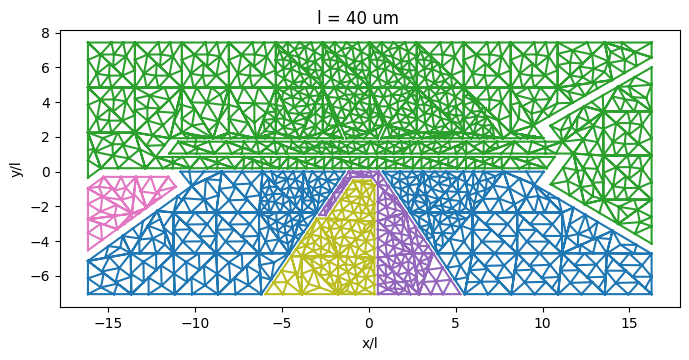

In [5]:
# set .1 max area within 3
# areas_from_constraints specifies sphere with finer mesh inside it.
mesh.areas_from_constraints(Sphere(center=np.array([0, 0, 1.]),
           radius=6, inside=0.2, outside=0.5))    # "inside", "outside" set different mesh densities.
# retriangulate quality and quiet with areas
mesh.triangulate(opts="qQ", new=False)
# save base mesh to vtk
mesh.to_vtk(prefix+suffix)
print("Output vtk:",os.path.abspath("./"+prefix+suffix+".vtk"))    # output path

# Plot triangle meshes.
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(8,6), dpi=100)
ax.set_xlabel("x/l",fontsize=10)
ax.set_ylabel("y/l",fontsize=10)
ax.text(-3,8.5,"l = %d um"%(scale/1e-6),fontsize=12)
mesh.plot(ax)

### Main boundary element calculations

In `run_job` function, `job` is `Configuration` instance and `grid` is discretirized spatial grid (not the mesh). The general workflow (also the routine of BEM method) are:  
1. `solve_singularities()` solves charge distributions by iterative methods to make it consistent with one electrode at 1V and others at 0V (unit potentials). `adapt_mesh()` refines meshes adaptively to achieve certain precision while solving sigulartities.
2. Compute potentials on given grid points by `simulate()`, based on the charge distributions gotten previously.
3. Potential data of each unit potential are saved seperately to a `Result` instance, and also export to VTK files.
4. Return total accumulated charge per electrode in the end.

Major calculations calls `fastlap` C library which uses a pre-conditioned, adaptive, multipole-accelerated algorithm for solving Laplace problem. Two parameters control multipole acceleration.
+ numMom, the number of multipole
+ numLev, the number of levels in the hierarchical spatial decomposition.  
num_lev=1 means direct computation without multipole acceleration. See fastlap ug.pdf and README.rst.

In [6]:
# Define calculation function.
def run_job(args):
    # job is Configuration instance.
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min angle 25 deg.
    job.adapt_mesh(triangles=4e2, opts="q25Q")
    job.adapt_mesh(triangles=1e3, opts="q25Q")
    # solve for surface charges
    job.solve_singularities(num_lev=3)
    # get potentials and fields
    result = job.simulate(grid, field=job.name=="RF", num_lev=2)    # For "RF", field=True computes the field.
    result.to_vtk(prefix)
    print("finished job %s" % job.name)
    return job.collect_charges()

Create a grid in unit of scaled length `l`. Only choose the interested region (trap center) to save time.

For reference, to compute Seidelin trap, grid shape = (60, 60, 60) takes 266 s, while shape = (150, 150, 150) takes 3369 s.

In [7]:
# grid to evalute potential and fields atCreate a grid in unit of scaled length l. Only choose the interested region (trap center) to save time.
n, s = 2*60, 0.02  
Lx, Ly, Lz = 3, 3, 3    # in the unit of scaled length l
sx, sy, sz = s, s, s
# ni is grid point number, si is step size. Thus to fix size on i direction you need to fix ni*si.
nx, ny, nz = [2*np.ceil(L/2.0/s).astype('int') for L in (Lx, Ly, Lz)]
print("Size/l:", Lx, Ly, Lz)
print("Step/l:", sx, sy, sz)
print("Shape (grid point numbers):", nx, ny, nz)
grid = Grid(center=(0, 1, 1), step=(sx, sy, sz), shape=(nx, ny, nz))
# Grid center (nx, ny ,nz)/2 is shifted to origin
print("Grid origin/l:", grid.get_origin()[0])

Size/l: 3 3 3
Step/l: 0.02 0.02 0.02
Shape (grid point numbers): 150 150 150
Grid origin/l: -1.49


Calculation. Parallel computation `Pool().map`

In [ ]:
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*","RF"))    # select() picks one electrode each time.
# run the different electrodes on the parallel pool
pmap = Pool().map # parallel map
# pmap = map # serial map
t0 = time()
list(pmap(run_job, ((job, grid, prefix+suffix) for job in jobs)))
print("Computing time:", time()-t0)
# run_job casts a word after finishing each electrode.

### Contour plot of potential/pseudo-potential in 3 directions

p max 63.3652
yz plane, RF pseudo


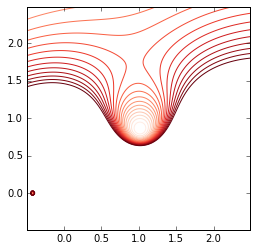

In [9]:
# isocontour plot of RF pseudopotential radially from x (axial) direction
result = Result.from_vtk(prefix+suffix, "RF")
p = result.pseudo_potential
maxp = np.amax(p)
print("p max", maxp)
x = grid.to_mgrid()[:, p.shape[0]//2]    # p.shape[0]/2 is in the middle of x.
p = p[p.shape[0]//2]    # get a slice of yz plane at x = p.shape[0]/2.
print("yz plane, RF pseudo")
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 20), cmap=plt.cm.Reds)

p max 1.00841
yz plane, DC1 potential


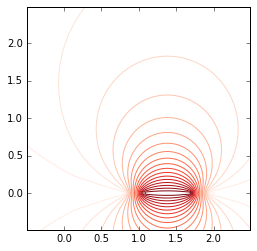

In [10]:
# isocontour plot of DC potential from x (axial) direction
ele = "DC1"
result = Result.from_vtk(prefix+suffix, ele)
p = result.potential
maxp = np.amax(p)
print("p max", maxp)
x = grid.to_mgrid()[:,p.shape[0]//2]
p = p[p.shape[0]//2]
print("yz plane, %s potential"%ele)
fig, ax = plt.subplots()
ax.set_aspect("equal")
# yz plane should use x[1], x[2]. wwc
ax.contour(x[1], x[2], p, levels=np.linspace(0, maxp, 20), cmap=plt.cm.Reds)    # 2e-2

p max 1.00841
xy plane, DC1 potential


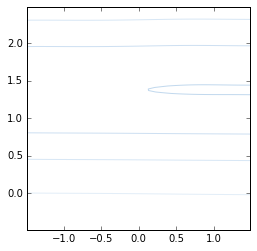

In [11]:
# isocontour plot of electrode potential (electrode profile) from z direction
ele = "DC1"
result = Result.from_vtk(prefix+suffix, ele)
p = result.potential
maxp = np.amax(p)
print("p max", maxp)
coord = grid.to_mgrid()
x = coord[:,:,:,p.shape[2]//2]
p = p[:,:,p.shape[2]//2]
print("xy plane, %s potential"%ele)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(0, maxp, 20), cmap=plt.cm.Blues)

p max 1.00841
xz plane, DC1 potential


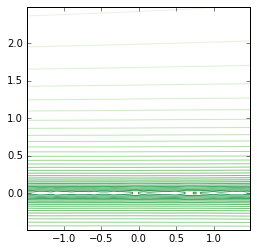

In [12]:
# isocontour plot of single DC potential from y direction
ele = "DC1"
result = Result.from_vtk(prefix+suffix, ele)
p = result.potential
maxp = np.amax(p)
print("p max", maxp)
x = grid.to_mgrid()[:,:,p.shape[1]//2]
p = p[:,p.shape[1]//2]
print("xz plane, %s potential"%ele)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[2], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Greens)

p max 6542.62925225
yz plane, superposition


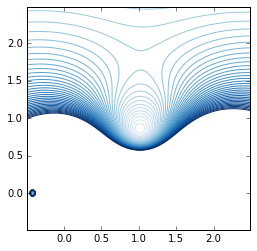

In [13]:
# isocontour plot of superpositioned potential
resultf = Result.from_vtk(prefix+suffix, "RF")
result1 = Result.from_vtk(prefix+suffix, "DC1")
result2 = Result.from_vtk(prefix+suffix, "DC4")
result3 = Result.from_vtk(prefix+suffix, "DC5")
pf = resultf.pseudo_potential
pdc = [result1.potential, result2.potential, result3.potential]
sf = 103.25
sdc = [1.5,3,5]
p = sf*pf
for it in range(len(sdc)):
    p += sdc[it]*pdc[it]
maxp = np.amax(p)
print("p max", maxp)
x = grid.to_mgrid()[:,p.shape[0]//2]
p = p[p.shape[0]//2]
print("yz plane, superposition")
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 5, 50), cmap=plt.cm.Blues)

In [14]:
result = Result.from_vtk(prefix+suffix, "DC1")
p = result.potential
print(coord.shape)    # length nx, ny, nz
print(coord[:,p.shape[0]//2].shape)    # plane at nx/2
print(p.shape)

(3, 150, 150, 150)
(3, 150, 150)
(150, 150, 150)


In [15]:
# Verify the symmetry of potential distribution (and then know axes).
print("x axis")
print(p[0,ny//2-1,nz//2-1], p[nx-1,ny//2-1,nz//2-1])
print(p[0+10,ny//2-1,nz//2-1], p[nx-1-10,ny//2-1,nz//2-1])  # x

print("y axis")
print(p[nx//2-1,0,nz//2-1], p[nx//2-1,ny-1,nz//2-1])
print(p[nx//2-1,0+10,nz//2-1], p[nx//2-1,ny-1-10,nz//2-1])  # y

print("z axis")
print(p[nx//2-1,ny//2-1,0], p[nx//2-1,ny//2-1,nz-1])
print(p[nx//2-1,ny//2-1,0+5], p[nx//2-1,ny//2-1,nz-1-5])  # z

x axis
0.241149 0.243591
0.241331 0.243464
y axis
0.0704889 0.135517
0.0828065 0.16314
z axis
0.362119 0.12076
0.398528 0.124569


### 3D plot of mesh and potential isocontour
By mayavi GUI (seems to have problem now.)

In [ ]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix+suffix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()

# Can't lauch GUI through X11 remote and caused dead kernel.

## Data processing
Using `electrode` package. (`GridElectrode.from_result()` method has problems for now, use `from_vtk()` directly.)  
I perfer to split data processing part to a new notebook. See `DataProcessing_SE.ipynb`.

In [ ]:
# electrode is an another package in nist-ionstorage github. wwc
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 DC6 RF".split():
    r = Result.from_vtk(prefix+suffix, name)
    e = GridElectrode.from_result(r,maxderiv=4)
#     e = GridElectrode.from_vtk("%s%s_"%(prefix,suffix)+name+".vtk",maxderiv=4)
    e.name = name
    s.append(e)

In [ ]:
import scipy.constants as ct
l = 40e-6 # length scale
u = 103.25 # peak rf voltage
o = 87e6*2*np.pi # rf frequency
m = 24.3*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
# coefficient of pseudo-potential. See blakestad2010 Eq.(5.2). Run rf_scale() before other calculations.
rf_scale = s.rf_scale(m,q,l,o)

# Set voltages (from Seidelin 2006 prl DOI: 10.1103/PhysRevLett.96.253003)
V5 = 5.0
DCvol = {"DC1":0.320*V5,"DC2":0.718*V5,"DC3":0.738*V5,"DC4":-0.898*V5,"DC5":V5,"DC6":0.0*V5}
for edc in DCvol:
    s[edc].dc = DCvol[edc]
    print(edc,s[edc].dc,"V")
s["RF"].rf = rf_scale*u    # s["RF"].rf = u*np.sqrt(q/m)/(2*l*o)
print("RF",s["RF"].rf,"V")

In [36]:
xi = (0.1, 1.0, 0.8)
# x0 = s.minimum(xi)
x0 = np.array([0.0,1.013,0.86])
print("minimum x0:",x0)
print("minimum offset: {}\n".format(x0-xi))
for line in s.analyze_static(x0, m=m, q=q, l=l, o=o, min_off=True):
    print(line)

minimum x0: [ 0.     1.013  0.86 ]
minimum offset: [-0.1    0.013  0.06 ]

parameters:
 f=87 MHz, m=24.3 amu, q=1 qe, l=40 µm, scale=0.0456 V'/V_SI
corrdinates:
 analyze point: [ 0.     1.013  0.86 ]
               ([  0.    40.52  34.4 ] µm)
 minimum is at offset: [ 0.  0.  0.]
                      ([ 0.  0.  0.] µm)
potential:
 dc electrical: 1.7 eV
 rf pseudo: 2.2 eV
 saddle offset: [ 0.30918665 -1.03397926 -0.09612845]
               ([ 12.3674661  -41.35917046  -3.84513817] µm)
 saddle height: -0.00085 eV
force:
 dc electrical: [-0.0003122   0.00014513  0.00031301] eV/l
               ([-7.80504463  3.62826036  7.82521121] eV/m)
 rf pseudo: [  1.56699685e-05   6.25775479e-04   5.74812820e-04] eV/l
           ([  0.39174921  15.64438698  14.37032051] eV/m)
modes:
 pp+dc normal curvatures: [ -1.39405334e-07   4.11074087e-08   4.32576538e-07]
 motion is bounded: False
 pseudopotential modes:
  a: nan MHz, [-0.46932319  0.60000793 -0.64786281]
  b: 0.001607 MHz, [ 0.87171596  0.19776

../../../electrode/electrode/system.py:954: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)


In [ ]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mg rid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(0, 2e-2, 21)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.Reds_r)